In [190]:
import numpy as np
import pandas as pd
import seaborn as sns
sns.color_palette("bright")


[(0.00784313725490196, 0.24313725490196078, 1.0),
 (1.0, 0.48627450980392156, 0.0),
 (0.10196078431372549, 0.788235294117647, 0.2196078431372549),
 (0.9098039215686274, 0.0, 0.043137254901960784),
 (0.5450980392156862, 0.16862745098039217, 0.8862745098039215),
 (0.6235294117647059, 0.2823529411764706, 0.0),
 (0.9450980392156862, 0.2980392156862745, 0.7568627450980392),
 (0.6392156862745098, 0.6392156862745098, 0.6392156862745098),
 (1.0, 0.7686274509803922, 0.0),
 (0.0, 0.8431372549019608, 1.0)]

In [ ]:
pds_xls = pd.read_excel("data/6Li_with_Daejeon16_gs_energy_from_Dropbox.xlsx")

In [ ]:
pds_xls.head()

In [ ]:
pds_xls.shape
pds_xls.shape

In [ ]:
pds_xls.pop(pds_xls.columns[1])
pds_xls.pop(pds_xls.columns[len(pds_xls.columns)-1])

In [ ]:
pds_xls

In [ ]:
# ds_xls.pop(pds_xls.columns[0])


In [ ]:
data  = pds_xls.to_numpy()
print(data.shape)

In [ ]:
datum = {'Nmax': N_Max, 'data': data}

In [ ]:
np.save( 'data/processed_extrapolation.npy', datum)

In [183]:
import numpy as np
X = np.load('data/processed_extrapolation.npy', allow_pickle=True)


In [185]:
print(X[()]['data'].shape)
print(X[()]['Nmax'].shape)



(19, 10)
(9,)


In [ ]:
# We have to figure out a network now, the idea is to get an ODE to integrate this.

In [112]:
import math
import numpy as np
from IPython.display import clear_output
from tqdm import tqdm_notebook as tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.color_palette("bright")
import matplotlib as mpl
import matplotlib.cm as cm

import torch
from torch import Tensor
from torch import nn
from torch.nn  import functional as F 
from torch.autograd import Variable

use_cuda = torch.cuda.is_available()


def ode_solve(z0, t0, t1, f):
    """
    Simplest Euler ODE initial value solver
    """
    h_max = 0.05
    n_steps = math.ceil((abs(t1 - t0)/h_max).max().item())

    h = (t1 - t0)/n_steps
    t = t0
    z = z0

    for i_step in range(n_steps):
        z = z + h * f(z, t)
        t = t + h
    return z



## Let us now figure out how to get a model.
class ODEF(nn.Module):
    def forward_with_grad(self, z, t, grad_outputs):
        """Compute f and a df/dz, a df/dp, a df/dt"""
        batch_size = z.shape[0]

        out = self.forward(z, t)

        a = grad_outputs
        adfdz, adfdt, *adfdp = torch.autograd.grad(
            (out,), (z, t) + tuple(self.parameters()), grad_outputs=(a),
            allow_unused=True, retain_graph=True
        )
        # grad method automatically sums gradients for batch items, we have to expand them back
        if adfdp is not None:
            adfdp = torch.cat([p_grad.flatten()
                              for p_grad in adfdp]).unsqueeze(0)
            adfdp = adfdp.expand(batch_size, -1) / batch_size
        if adfdt is not None:
            adfdt = adfdt.expand(batch_size, 1) / batch_size
        return out, adfdz, adfdt, adfdp

    def flatten_parameters(self):
        p_shapes = []
        flat_parameters = []
        for p in self.parameters():
            p_shapes.append(p.size())
            flat_parameters.append(p.flatten())
        return torch.cat(flat_parameters)

In [113]:
class ODEAdjoint(torch.autograd.Function):
    @staticmethod
    def forward(ctx, z0, t, flat_parameters, func):
        assert isinstance(func, ODEF)
        bs, *z_shape = z0.size()
        time_len = t.size(0)

        with torch.no_grad():
            z = torch.zeros(time_len, bs, *z_shape).to(z0)
            z[0] = z0
            for i_t in range(time_len - 1):
                z0 = ode_solve(z0, t[i_t], t[i_t+1], func)
                z[i_t+1] = z0

        ctx.func = func
        ctx.save_for_backward(t, z.clone(), flat_parameters)
        return z

    @staticmethod
    def backward(ctx, dLdz):
        """
        dLdz shape: time_len, batch_size, *z_shape
        """
        func = ctx.func
        t, z, flat_parameters = ctx.saved_tensors
        time_len, bs, *z_shape = z.size()
        n_dim = np.prod(z_shape)
        n_params = flat_parameters.size(0)

        # Dynamics of augmented system to be calculated backwards in time
        def augmented_dynamics(aug_z_i, t_i):
            """
            tensors here are temporal slices
            t_i - is tensor with size: bs, 1
            aug_z_i - is tensor with size: bs, n_dim*2 + n_params + 1
            """
            z_i, a = aug_z_i[:, :n_dim], aug_z_i[:, n_dim:2*n_dim]  # ignore parameters and time

            # Unflatten z and a
            z_i = z_i.view(bs, *z_shape)
            a = a.view(bs, *z_shape)
            with torch.set_grad_enabled(True):
                t_i = t_i.detach().requires_grad_(True)
                z_i = z_i.detach().requires_grad_(True)
                func_eval, adfdz, adfdt, adfdp = func.forward_with_grad(z_i, t_i, grad_outputs=a)  # bs, *z_shape
                adfdz = adfdz.to(z_i) if adfdz is not None else torch.zeros(bs, *z_shape).to(z_i)
                adfdp = adfdp.to(z_i) if adfdp is not None else torch.zeros(bs, n_params).to(z_i)
                adfdt = adfdt.to(z_i) if adfdt is not None else torch.zeros(bs, 1).to(z_i)

            # Flatten f and adfdz
            func_eval = func_eval.view(bs, n_dim)
            adfdz = adfdz.view(bs, n_dim) 
            return torch.cat((func_eval, -adfdz, -adfdp, -adfdt), dim=1)

        dLdz = dLdz.view(time_len, bs, n_dim)  # flatten dLdz for convenience
        with torch.no_grad():
            ## Create placeholders for output gradients
            # Prev computed backwards adjoints to be adjusted by direct gradients
            adj_z = torch.zeros(bs, n_dim).to(dLdz)
            adj_p = torch.zeros(bs, n_params).to(dLdz)
            # In contrast to z and p we need to return gradients for all times
            adj_t = torch.zeros(time_len, bs, 1).to(dLdz)

            for i_t in range(time_len-1, 0, -1):
                z_i = z[i_t]
                t_i = t[i_t]
                f_i = func(z_i, t_i).view(bs, n_dim)

                # Compute direct gradients
                dLdz_i = dLdz[i_t]
                dLdt_i = torch.bmm(torch.transpose(dLdz_i.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

                # Adjusting adjoints with direct gradients
                adj_z += dLdz_i
                adj_t[i_t] = adj_t[i_t] - dLdt_i

                # Pack augmented variable
                aug_z = torch.cat((z_i.view(bs, n_dim), adj_z, torch.zeros(bs, n_params).to(z), adj_t[i_t]), dim=-1)

                # Solve augmented system backwards
                aug_ans = ode_solve(aug_z, t_i, t[i_t-1], augmented_dynamics)

                # Unpack solved backwards augmented system
                adj_z[:] = aug_ans[:, n_dim:2*n_dim]
                adj_p[:] += aug_ans[:, 2*n_dim:2*n_dim + n_params]
                adj_t[i_t-1] = aug_ans[:, 2*n_dim + n_params:]

                del aug_z, aug_ans

            ## Adjust 0 time adjoint with direct gradients
            # Compute direct gradients 
            dLdz_0 = dLdz[0]
            dLdt_0 = torch.bmm(torch.transpose(dLdz_0.unsqueeze(-1), 1, 2), f_i.unsqueeze(-1))[:, 0]

            # Adjust adjoints
            adj_z += dLdz_0
            adj_t[0] = adj_t[0] - dLdt_0
        return adj_z.view(bs, *z_shape), adj_t, adj_p, None

In [114]:
class NeuralODE(nn.Module):
    def __init__(self, func):
        super(NeuralODE, self).__init__()
        assert isinstance(func, ODEF)
        self.func = func

    def forward(self, z0, t=Tensor([0., 1.]), return_whole_sequence=False):
        t = t.to(z0)
        # print("the data", t, t.size(), z0.size())
        z = ODEAdjoint.apply(z0, t, self.func.flatten_parameters(), self.func)
        if return_whole_sequence:
            return z
        else:
            return z[-1]

In [115]:
class NNODEF(ODEF):
    def __init__(self, in_dim, hid_dim, time_invariant=False):
        super(NNODEF, self).__init__()
        self.time_invariant = time_invariant
        
        if time_invariant:
            self.lin1 = nn.Linear(in_dim, hid_dim)
        else:
            self.lin1 = nn.Linear(in_dim+1, hid_dim)
        self.lin2     = nn.Linear(hid_dim, hid_dim)
        self.lin3     = nn.Linear(hid_dim, in_dim)
        self.elu      = nn.ELU(inplace=True)

    def forward(self, x, t):
        # print(x.shape, t.shape)
        if not self.time_invariant:
            x = torch.cat((x, t.reshape([1,-1]) ), dim=-1)
        # print(x.shape)
        h = self.elu(self.lin1(x))
        h = self.elu(self.lin2(h))
        out = self.lin3(h)
        return out
    
def to_np(x):
    return x.detach().cpu().numpy()


In [155]:
def conduct_experiment(X, ode_trained, n_steps):
    
    z0 = Variable(torch.Tensor([[0.6, 0.3]]))
    

    permutation = np.random.randint(0,n_points)
    E= X[()]['data'][:,1:]
    h_omega = X[()]['data'][:,0]/50
    N_Max = X[()]['Nmax'].reshape([-1])/18
    n_points =h_omega.shape[0]

    permutation = [np.random.randint(0, n_points) for k in range(10)]

    ETr = E[permutation]
    h_omegaT = h_omega[permutation]

    


    def create_batch(X, y, T):
        idx  = np.random.randint(0, n_points)      
        ho_  = y[idx].astype(np.float32)
        obs_ = X[idx, :].astype(np.float32)
        ts_  = np.vstack(T).astype(np.float32)
        # print(idx, ho_.dtype, obs_.dtype, ts_.dtype)
        return torch.from_numpy(np.array(obs_)), torch.from_numpy(np.array(ts_)), ho_

    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=0.01)
    for i in range(n_steps):
        obs_, ts_, ho_ = create_batch()
        print(obs_[0], torch.tensor(ho_))
        input_d= torch.cat([obs_[0].reshape([1,-1]), torch.tensor(ho_).reshape([1, -1 ])], axis = 1)
        print(input_d.shape, ts_)
        z_ = ode_trained(input_d, ts_, return_whole_sequence=True).squeeze(1)
        input_d = torch.cat([obs_.reshape([-1,1]), torch.tensor(np.tile(ho_, 9)).reshape([-1,1])], axis=1)
        print(z_, z_.shape, input_d.shape)
        loss = F.mse_loss(z_, input_d.detach())
        print("The loss is:", loss.item(), "at step", i)
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

In [156]:
func = NNODEF(2, 20, time_invariant=False)
ode_trained = NeuralODE(func)
conduct_experiment(X, ode_trained, 5)


tensor(-25.7044) tensor(0.4000)
torch.Size([1, 2]) tensor([[0.1111],
        [0.2222],
        [0.3333],
        [0.4444],
        [0.5556],
        [0.6667],
        [0.7778],
        [0.8889],
        [1.0000]])
tensor([[-25.7044,   0.4000],
        [-25.8297,   0.5921],
        [-25.9523,   0.7868],
        [-26.0724,   0.9841],
        [-26.1898,   1.1840],
        [-26.3046,   1.3866],
        [-26.4167,   1.5918],
        [-26.5261,   1.7997],
        [-26.6328,   2.0101]], grad_fn=<SqueezeBackward1>) torch.Size([9, 2]) torch.Size([9, 2])
The loss is: 11.284282684326172 at step 0
tensor(-26.0586) tensor(0.3500)
torch.Size([1, 2]) tensor([[0.1111],
        [0.2222],
        [0.3333],
        [0.4444],
        [0.5556],
        [0.6667],
        [0.7778],
        [0.8889],
        [1.0000]])
tensor([[-26.0586,   0.3500],
        [-26.3762,   0.4897],
        [-26.6940,   0.6324],
        [-27.0121,   0.7781],
        [-27.3303,   0.9269],
        [-27.6487,   1.0787],
        [-27.

In [ ]:
# Latent ODE Models

In [157]:
class RNNEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(RNNEncoder, self).__init__()
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.rnn = nn.GRU(input_dim+1, hidden_dim)
        self.hid2lat = nn.Linear(hidden_dim, 2*latent_dim)

    def forward(self, x, t):
        # Concatenate time to input
        t = t.clone()
        t[1:] = t[:-1] - t[1:]
        t[0] = 0.
        xt = torch.cat((x, t), dim=-1)

        _, h0 = self.rnn(xt.flip((0,)))  # Reversed
        # Compute latent dimension
        z0 = self.hid2lat(h0[0])
        z0_mean = z0[:, :self.latent_dim]
        z0_log_var = z0[:, self.latent_dim:]
        return z0_mean, z0_log_var


In [158]:
class NeuralODEDecoder(nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(NeuralODEDecoder, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        func = NNODEF(latent_dim, hidden_dim, time_invariant=True)
        self.ode = NeuralODE(func)
        self.l2h = nn.Linear(latent_dim, hidden_dim)
        self.h2o = nn.Linear(hidden_dim, output_dim)

    def forward(self, z0, t):
        zs = self.ode(z0, t, return_whole_sequence=True)

        hs = self.l2h(zs)
        xs = self.h2o(hs)
        return xs


In [159]:
class ODEVAE(nn.Module):
    def __init__(self, output_dim, hidden_dim, latent_dim):
        super(ODEVAE, self).__init__()
        self.output_dim = output_dim
        self.hidden_dim = hidden_dim
        self.latent_dim = latent_dim

        self.encoder = RNNEncoder(output_dim, hidden_dim, latent_dim)
        self.decoder = NeuralODEDecoder(output_dim, hidden_dim, latent_dim)

    def forward(self, x, t, MAP=False):
        z_mean, z_log_var = self.encoder(x, t)
        if MAP:
            z = z_mean
        else:
            z = z_mean + torch.randn_like(z_mean) * torch.exp(0.5 * z_log_var)
        x_p = self.decoder(z, t)
        return x_p, z, z_mean, z_log_var

    def generate_with_seed(self, seed_x, t):
        seed_t_len = seed_x.shape[0]
        z_mean, z_log_var = self.encoder(seed_x, t[:seed_t_len])
        x_p = self.decoder(z_mean, t)
        return x_p


In [237]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns

CB91_Blue = '#05e1e1'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = ['#405952',
              '#9C9B7A',
              '#FFD393',
              '#FF974F',
              '#F54F29',
              ]
CB91_Grad_BP = ['#2cbdfe', '#2fb9fc', '#33b4fa', '#36b0f8',
                '#3aacf6', '#3da8f4', '#41a3f2', '#449ff0',
                '#489bee', '#4b97ec', '#4f92ea', '#528ee8',
                '#568ae6', '#5986e4', '#5c81e2', '#607de0',
                '#6379de', '#6775dc', '#6a70da', '#6e6cd8',
                '#7168d7', '#7564d5', '#785fd3', '#7c5bd1',
                '#7f57cf', '#8353cd', '#864ecb', '#894ac9',
                '#8d46c7', '#9042c5', '#943dc3', '#9739c1',
                '#9b35bf', '#9e31bd', '#a22cbb', '#a528b9',
                '#a924b7', '#ac20b5', '#b01bb3', '#b317b1']

small = 16
med = 18
large = 20




def to_np(x):
    return x.detach().numpy()

def conduct_experiment_latent(X, ode_trained, n_steps):

    z0 = Variable(torch.Tensor([[0.6, 0.3]]))

    E = X[()]['data'][:, 1:]
    h_omega = X[()]['data'][:, 0]/50
    N_Max = X[()]['Nmax'].reshape([-1])/18
    n_points = h_omega.shape[0]
    noise_std = 1
    permutation = [np.random.randint(0, n_points) for k in range(10)]
    ETr = E[permutation]
    h_omegaT = h_omega[permutation]

    def create_batch_latent(X, y):
        idx = [ np.random.randint(0, X.shape[0]) for _ in range(20) ]

        obs_=torch.from_numpy( X[idx, :].astype(np.float32).T).unsqueeze(2)

        ts_ = np.vstack(N_Max).astype(np.float32).reshape([-1, 1])
        ts_ = torch.from_numpy(np.repeat(ts_, obs_.shape[1], axis=1)).unsqueeze(2)


        ho_ = torch.from_numpy( np.repeat( y[idx].astype(
            np.float32).reshape([1,-1]), obs_.shape[0], axis = 0)).unsqueeze(2)
        
        # print(ho_.dtype, obs_.dtype, ts_.dtype)
        # print(ho_.shape, obs_.shape, ts_.shape)

        
        return obs_, ts_, ho_

    # Train Neural ODE
    optimizer = torch.optim.Adam(ode_trained.parameters(), lr=1e-3)
    for i in range(n_steps):
        obs_, ts_, ho_ = create_batch_latent(ETr, h_omegaT)
        input_d = torch.cat( [obs_, ho_], axis=2)
        # print(input_d, input_d.shape, ts_)
        # z_ = ode_trained(input_d, ts_, return_whole_sequence=True).squeeze(1)
        x_p, z, z_mean, z_log_var = ode_trained(input_d, ts_)
        # input_d = torch.cat(
        #     [obs_.reshape([-1, 1]), torch.tensor(np.tile(ho_, 9)).reshape([-1, 1])], axis=1)
        kl_loss = -0.5 * torch.sum(1 + z_log_var - z_mean**2 - torch.exp(z_log_var), -1)
        error_loss = 0.5 * ((input_d-x_p)**2).sum(-1).sum(0) / noise_std**2
        loss = torch.mean(error_loss+ kl_loss)

        
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()
    
        if i %1000 == 0:
            obs_, ts_, ho_ = create_batch_latent(E, h_omega)
            input_d = torch.cat([obs_, ho_], axis=2)

            samp_trajs_p = to_np(ode_trained.generate_with_seed(input_d, ts_))
            print(samp_trajs_p.shape)

            plt.figure()
            
            fig, axes = plt.subplots(nrows=3, ncols=6, figsize=(9, 9), sharex = True, sharey = True, dpi = 400)
            axes = axes.flatten()
            for j, ax in enumerate(axes):
                
                ax.plot(ts_[:, j, 0], input_d[:, j, 0], label='real', linewidth = 1)
                ax.scatter(ts_[:, j, 0], samp_trajs_p[:, j, 0], 3,
                           label='predicted', marker='*',
                           c=samp_trajs_p[:, j, 0], cmap=cm.plasma)
                
                if j == 5:
                    ax.legend(bbox_to_anchor=(1.05, 1.0), loc='upper left')
                if j == 0 or j==6 or j ==12:
                    ax.set_ylabel('Ground state Energy', fontsize = 10)
                if j >11:
                    ax.set_xlabel('NMax', fontsize = 10)
            print("Step:", i, "Total_Loss:"+str(loss.item()) + " mean squared error",\
            str(torch.mean(error_loss).item())+" KL divergence"+ str(torch.mean(kl_loss).item()) )
            plt.savefig('Figures/reconstruction_'+str(i)+'.png', dpi= 300)
            plt.show()




(9, 20, 2)
Step: 0 Total_Loss:3274.498779296875 with error 3273.62255859375 KL divergence0.8758807182312012


<Figure size 432x288 with 0 Axes>

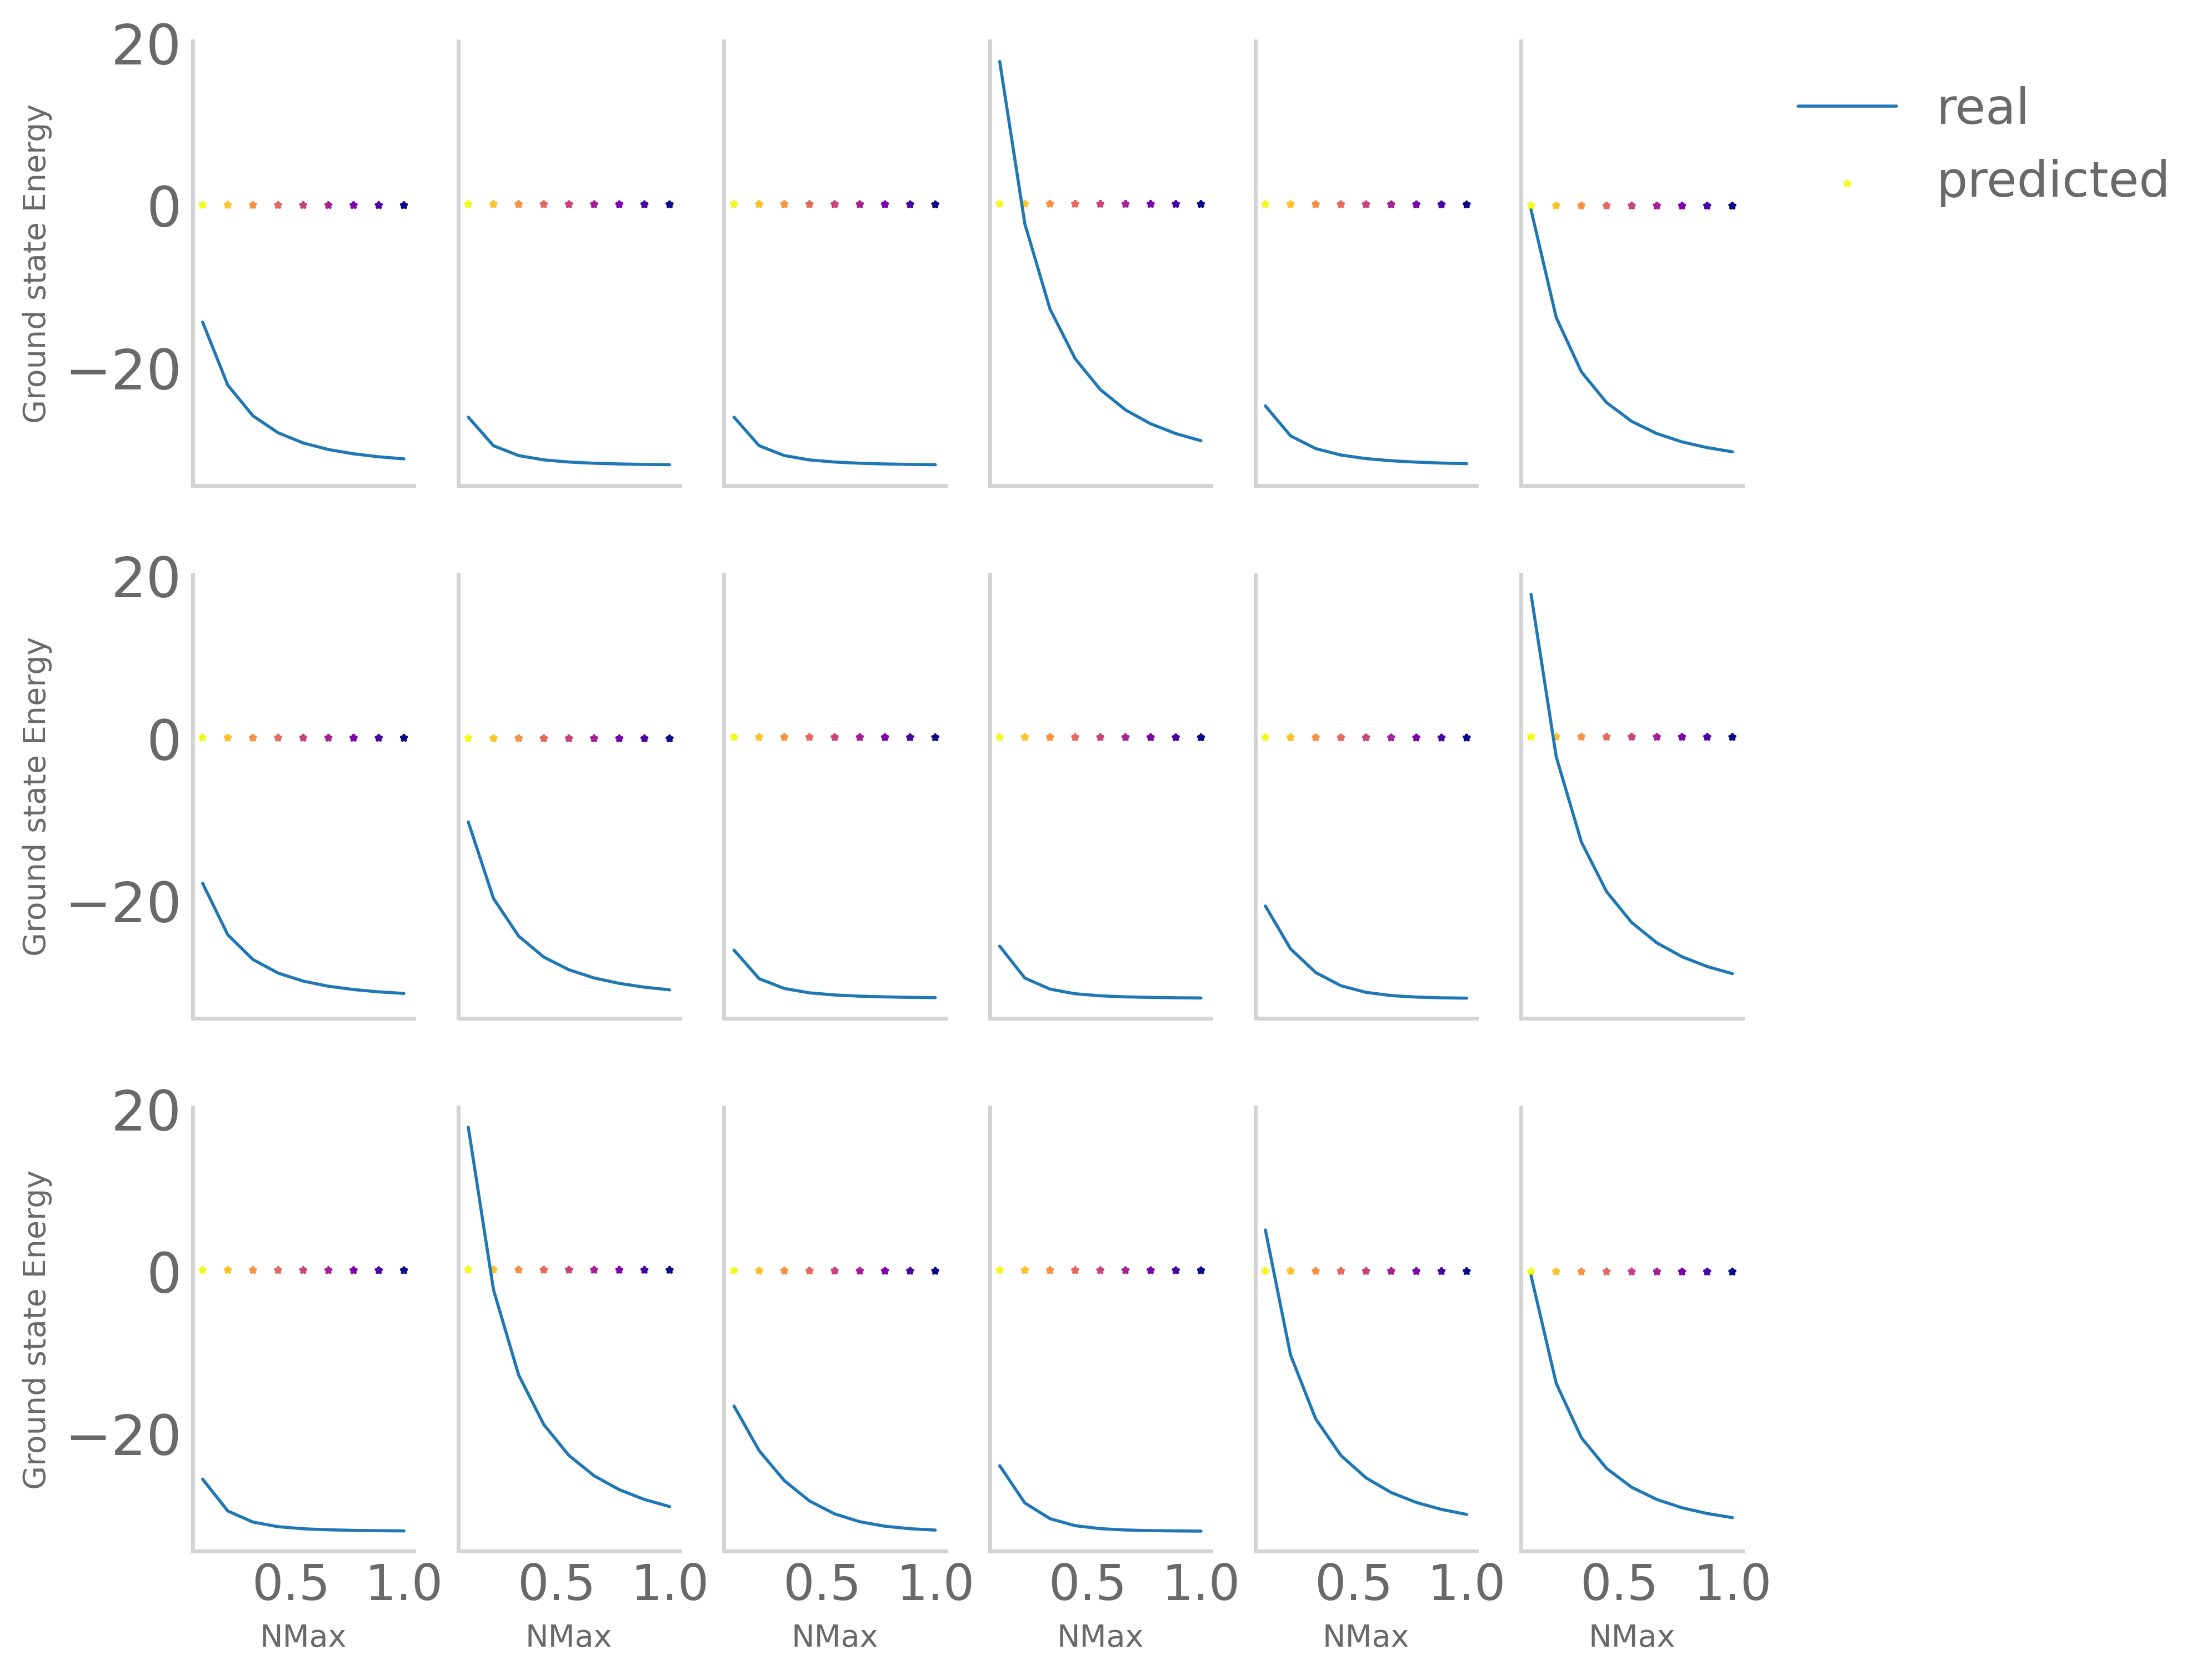

KeyboardInterrupt: 

In [238]:
ode_trained = ODEVAE(2, 64, 6)
conduct_experiment_latent(X, ode_trained, 30000)


In [ ]:
## Test Spiral

In [119]:
class LinearODEF(ODEF):
    def __init__(self, W):
        super(LinearODEF, self).__init__()
        self.lin = nn.Linear(2, 2, bias=False)
        self.lin.weight = nn.Parameter(W)

    def forward(self, x, t):
        return self.lin(x)


In [120]:
class SpiralFunctionExample(LinearODEF):
    def __init__(self):
        super(SpiralFunctionExample, self).__init__(
            Tensor([[-0.1, -1.], [1., -0.1]]))


In [121]:
t_max = 6.29*5
n_points = 200
noise_std = 0.02

num_spirals = 1000

index_np = np.arange(0, n_points, 1, dtype=np.int)
index_np = np.hstack([index_np[:, None]])
times_np = np.linspace(0, t_max, num=n_points)
times_np = np.hstack([times_np[:, None]] * num_spirals)
times = torch.from_numpy(times_np[:, :, None]).to(torch.float32)

# Generate random spirals parameters
normal01 = torch.distributions.Normal(0, 1.0)

x0 = Variable(normal01.sample((num_spirals, 2))) * 2.0

W11 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W22 = -0.1 * normal01.sample((num_spirals,)).abs() - 0.05
W21 = -1.0 * normal01.sample((num_spirals,)).abs()
W12 = 1.0 * normal01.sample((num_spirals,)).abs()

xs_list = []
for i in range(num_spirals):
    if i % 2 == 1:  # Make it counter-clockwise
        W21, W12 = W12, W21

    func = LinearODEF(Tensor([[W11[i], W12[i]], [W21[i], W22[i]]]))
    ode = NeuralODE(func)

    xs = ode(x0[i:i+1], times[:, i:i+1], return_whole_sequence=True)
    xs_list.append(xs)


orig_trajs = torch.cat(xs_list, dim=1).detach()
samp_trajs = orig_trajs + torch.randn_like(orig_trajs) * noise_std
samp_ts = times


/var/folders/22/g5vqm_691y3dffxdf0vnnzvr0000gn/T/ipykernel_38228/1563495854.py:7: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  index_np = np.arange(0, n_points, 1, dtype=np.int)


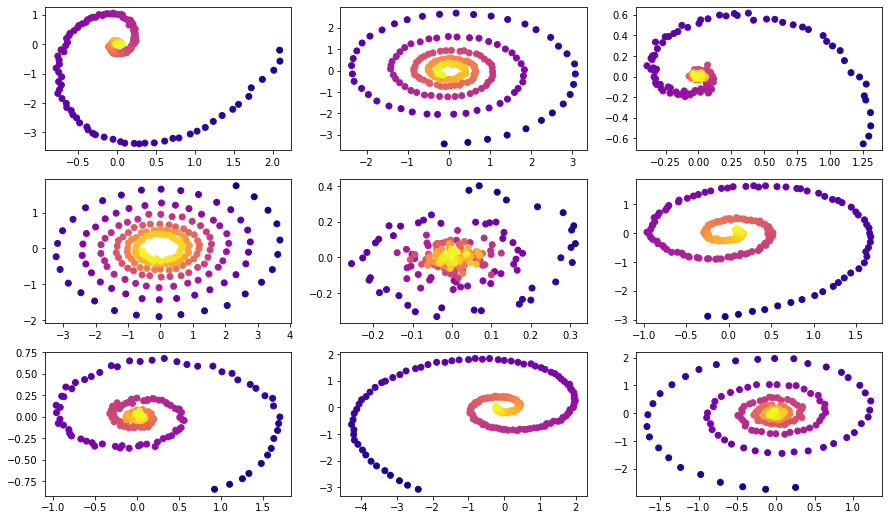

In [122]:
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
axes = axes.flatten()
for i, ax in enumerate(axes):
    ax.scatter(samp_trajs[:, i, 0], samp_trajs[:, i, 1],
               c=samp_ts[:, i, 0], cmap=cm.plasma)
plt.show()


In [123]:
import numpy.random as npr


def gen_batch(batch_size, n_sample=100):
    n_batches = samp_trajs.shape[1] // batch_size
    time_len = samp_trajs.shape[0]

    n_sample = min(n_sample, time_len)
    for i in range(n_batches):
        if n_sample > 0:
            t0_idx = npr.multinomial(
                1, [1. / (time_len - n_sample)] * (time_len - n_sample))
            t0_idx = np.argmax(t0_idx)
            tM_idx = t0_idx + n_sample
        else:
            t0_idx = 0
            tM_idx = time_len

        frm, to = batch_size*i, batch_size*(i+1)
        yield samp_trajs[t0_idx:tM_idx, frm:to], samp_ts[t0_idx:tM_idx, frm:to]


In [124]:
vae = ODEVAE(2, 64, 6)
optim = torch.optim.Adam(vae.parameters(), betas=(0.9, 0.999), lr=0.001)

In [125]:
preload = False
n_epochs = 20000
batch_size = 100

plot_traj_idx = 1
plot_traj = orig_trajs[:, plot_traj_idx:plot_traj_idx+1]
plot_obs = samp_trajs[:, plot_traj_idx:plot_traj_idx+1]
plot_ts = samp_ts[:, plot_traj_idx:plot_traj_idx+1]

for epoch_idx in range(n_epochs):
    losses = []
    train_iter = gen_batch(batch_size)
    for x, t in train_iter:
        optim.zero_grad()

        max_len = np.random.choice([30, 50, 100])
        permutation = np.random.permutation(t.shape[0])
        np.random.shuffle(permutation)
        permutation = np.sort(permutation[:max_len])

        x, t = x[permutation], t[permutation]
        print(x.shape, t.shape)
        x_p, z, z_mean, z_log_var = vae(x, t)
        print(x_p.shape, z.shape, z_mean.shape, z_log_var.shape)
        kl_loss = -0.5 * torch.sum(1 + z_log_var -
                                   z_mean**2 - torch.exp(z_log_var), -1)
        loss = 0.5 * ((x-x_p)**2).sum(-1).sum(0) / noise_std**2 + kl_loss
        loss = torch.mean(loss)
        loss /= max_len
        loss.backward()
        optim.step()
        losses.append(loss.item())

    print(f"Epoch {epoch_idx}")

    frm, to, to_seed = 0, 200, 50
    seed_trajs = samp_trajs[frm:to_seed]
    ts = samp_ts[frm:to]

    samp_trajs_p = to_np(vae.generate_with_seed(seed_trajs, ts))

    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 9))
    axes = axes.flatten()
    for i, ax in enumerate(axes):
        ax.scatter(to_np(seed_trajs[:, i, 0]), to_np(
            seed_trajs[:, i, 1]), c=to_np(ts[frm:to_seed, i, 0]), cmap=cm.plasma)
        ax.plot(to_np(orig_trajs[frm:to, i, 0]),
                to_np(orig_trajs[frm:to, i, 1]))
        ax.plot(samp_trajs_p[:, i, 0], samp_trajs_p[:, i, 1])
    plt.show()

    print(np.mean(losses), np.median(losses))
    clear_output(wait=True)

torch.Size([50, 100, 2]) torch.Size([50, 100, 1])
torch.Size([50, 100, 2]) torch.Size([100, 6]) torch.Size([100, 6]) torch.Size([100, 6])
torch.Size([50, 100, 2]) torch.Size([50, 100, 1])
torch.Size([50, 100, 2]) torch.Size([100, 6]) torch.Size([100, 6]) torch.Size([100, 6])
torch.Size([30, 100, 2]) torch.Size([30, 100, 1])
torch.Size([30, 100, 2]) torch.Size([100, 6]) torch.Size([100, 6]) torch.Size([100, 6])
torch.Size([50, 100, 2]) torch.Size([50, 100, 1])
torch.Size([50, 100, 2]) torch.Size([100, 6]) torch.Size([100, 6]) torch.Size([100, 6])
torch.Size([30, 100, 2]) torch.Size([30, 100, 1])
torch.Size([30, 100, 2]) torch.Size([100, 6]) torch.Size([100, 6]) torch.Size([100, 6])
torch.Size([30, 100, 2]) torch.Size([30, 100, 1])
torch.Size([30, 100, 2]) torch.Size([100, 6]) torch.Size([100, 6]) torch.Size([100, 6])
torch.Size([50, 100, 2]) torch.Size([50, 100, 1])
torch.Size([50, 100, 2]) torch.Size([100, 6]) torch.Size([100, 6]) torch.Size([100, 6])
torch.Size([50, 100, 2]) torch.Siz

KeyboardInterrupt: 